
#  Confidence Intervals

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

source: https://www.coursera.org/learn/mathematical-statistics-and-ab-testing/home/week/3

In [5]:
def norm_conf_int(alpha, mean_hat, std_hat, margin = 5):
    """
        Строит 95% асимптотически-нормальный доверительный интервал
    """
    
    plt.figure(figsize=(10,5))
    xs = np.linspace(mean_hat - margin, mean_hat + margin)
    pdf = stats.norm(mean_hat, std_hat).pdf(xs)

    plt.plot(xs, pdf)
    plt.ylabel('$f(x)$', fontsize=18)
    plt.xlabel('$x$', fontsize=18)

    left, right = stats.norm.interval(1 - alpha, loc=mean_hat, scale=std_hat)
    
    for i in [left, right]: 
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)
        
        if i == left:
            xq = np.linspace(mean_hat - margin, left)
        else:
            xq = np.linspace(right, mean_hat + margin)
        
        text_margin = 0.05
        plt.text(i + text_margin, 0.8*y_max, round(i, 2), color="blue", fontsize=14)
        yq = stats.norm(mean_hat, std_hat).pdf(xq)
        plt.fill_between(xq, 0, yq, color='blue', alpha=0.3)

    return left, right

In [43]:
# get built-in dataset on houses in boston
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston['data'], columns = [x.lower() for x in boston['feature_names']])

In [10]:
df = pd.read_csv('flat.csv', sep='\t')
print(df.shape)
df.head()

(2040, 11)


,n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


# 1. Доверительные интервалы для среднего



__Асимптотический доверительный интервал:__

$$
\bar x \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat s^2}{n}}.
$$

> __Предположения:__ 
В выборке нет аномалий, собиралась независимо, тогда среднее асимптотически нормально распределено (ЦПТ) 

In [49]:
# manually 
norm_rv = stats.norm()

alpha = 0.05
z_crit = norm_rv.ppf(1 - alpha/2)

mu_hat = df.age.mean() 
var_hat = df.age.var(ddof=1)
n = df.age.count()

left = mu_hat - z_crit*np.sqrt(var_hat/n)
right = mu_hat + z_crit*np.sqrt(var_hat/n)

print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4} и среднего {:.4}".format(left, right, right - left, mu_hat))

Доверительный интервал [66.12; 71.03] ширины 4.905 и среднего 68.57


In [46]:
# with scipy function
mu_hat = df.age.mean() 
sd_hat = df.age.std(ddof=1)/np.sqrt(n)

stats.norm.interval(0.95, loc = mu_hat, scale = sd_hat)

(66.12226198491352, 71.02754038662805)

(66.12226198491352, 71.02754038662805)

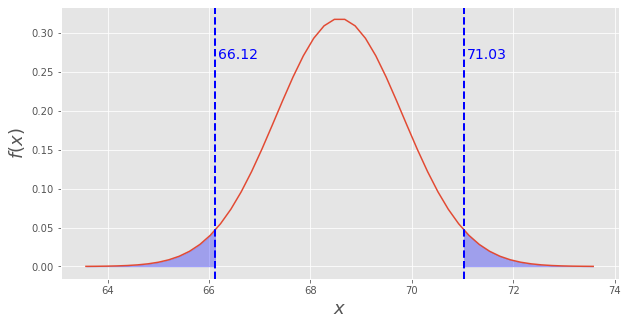

In [61]:
# with our hand-made function
alpha = 0.05
mu_hat = df.age.mean() 
sd_hat = df.age.std(ddof=1)/np.sqrt(n)

norm_conf_int(alpha, mu_hat, sd_hat, margin=5)

__Точный доверительный интервал:__

$$
\bar x \pm t_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat s^2}{n}}.
$$

> __Предположения:__ 
Выборка пришла из нормального распределения, дисперсия неизвестна, ddof = n-1

In [50]:
# manually 
n = df.age.count()
t_rv = stats.t(n - 1)

alpha = 0.05
t_crit = t_rv.ppf(1 - alpha/2)

mu_hat = df.age.mean() 
var_hat = df.age.var(ddof = 1)


left = mu_hat - t_crit*np.sqrt(var_hat/n)
right = mu_hat + t_crit*np.sqrt(var_hat/n)

print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [66.12; 71.03] ширины 4.917


In [16]:
# Оказался немного шире, но похож, так как:
# t(n) => N(0,1) при n -> inf 

In [62]:
# with scipy function 
n = df.age.count()
mu_hat = df.age.mean()
sd_hat = df.age.std(ddof=1) / np.sqrt(n)

# тут 0.95 это 1 - alpha
left, right = stats.t.interval(0.95, df=(n-1), loc=mu_hat, scale=sd_hat)
print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))


Доверительный интервал [66.12; 71.03] ширины 4.917


> Видим, что интервалы не сильно отличаются друг от друга, из-за того, что у нас в выборке много наблюдений. При большом числе степеней свободы распределение Стьюдента похоже на нормальное. Тем не менее даже при большом количестве наблюдений точный доверительный интервал оказывается немного шире. 

# 2. Доверительный интервал для разности средних

Построим $95\%$ асимптотический доверительный интервал для разницы в среднем возрасте домов.
$$
\bar x - \bar y \pm z_{crit} \cdot \sqrt{\frac{\hat\sigma_x^2}{n_x} + \frac{\hat\sigma_y^2}{n_y}}
$$

In [63]:
x = df[df.crim > 0.256510].age.values # houses in neighbourhoods with high crime level
y = df[df.crim <= 0.256510].age.values # houses in neighbourhoods with lower crime level

diff = x.mean() - y.mean() 
nx,ny = x.size, y.size
diff_sd = np.sqrt(x.var(ddof = 1)/nx + y.var(ddof=1)/nx)

left, right = stats.norm.interval(0.95, loc=diff, scale=diff_sd)
print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [30.65; 38.41] ширины 7.752


__Точный доверительный интервал:__

Предположим, что дисперсии неизвестны, но равны.

$$
\bar x - \bar y \pm t_{crit} \cdot \sqrt{\frac{s^2}{n_x} + \frac{s^2}{n_y}}
$$

- Pooled variance procedure:
$$se(\overline x - \overline y) = s_p \sqrt{\frac{1}{n} + \frac{1}{m}}$$
where $s_p^2 = \frac{(n-1)s_x^2 + (m-1) s_y^2}{n+m-2}$

- Assume $\sigma_A^2 = \sigma_B^2 = \sigma^2$

- Unbiased estimate of $\hat{\sigma}^2$ of $\sigma^2$ is given by:
$$s_p^2 = \frac{(n-1)s_x^2 + (m-1) s_y^2}{n+m-2}$$

- t-statistics becomes
$$T = \frac{ \overline x - \overline y - (\mu_A  - \mu_B)}{s_p \sqrt{\frac{1}{n} + \frac{1}{m}} } \sim t_{n+m-2}$$


In [64]:
diff = x.mean() - y.mean()
nx, ny = x.size, y.size

s2 = ((nx - 1)*x.var() + (ny - 1)*y.var())/(nx + ny - 2)
diff_sd = np.sqrt(s2/nx + s2/ny)

left, right = stats.t.interval(0.95, df=(nx + ny - 2), loc=diff, scale=diff_sd)
print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [30.65; 38.41] ширины 7.755


Получился немного шире, чем асимптотический

In [24]:
x.var(), y.var()

(4264.981392232218, 1668.1298841576563)

Предположим, что дисперсии неизвестны и не равны. Построим приближённый доверительный интервал (интервал Уэлча).

- We use the statistics
$$T = \frac{ \bar{x} - \bar{y} - (\mu_A - \mu_B)}{\sqrt{\frac{s_x^2}{n} + \frac{s_y^2}{m}}}$$

- This statistic follows approximately t-distribution with the d.f. $\nu$  as the
largest integer not larger than
$$v^* = \frac{ (s_x^2 / n + s_y^2 /m ) ^2}{ s_x^4/ n^2(n-1) + s_y^4 / m^2(m-1) }$$

In [65]:
diff = x.mean() - y.mean()
nx, ny = x.size, y.size
diff_sd = np.sqrt(x.var()/nx + y.var()/ny)

u = (x.var() / nx + y.var() / ny) ** 2
d = (x.var()**2) / (nx**2 * (nx - 1)) + (y.var()**2)/ (ny**2* (ny - 1))
nu =  u/d 
print("Число степеней свободы:", nu)

left, right = stats.t.interval(0.95, df=nu, loc=diff, scale=diff_sd)
print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))


Число степеней свободы: 447.8312921348487
Доверительный интервал [30.65; 38.41] ширины 7.757


In [26]:
nx, ny

(659, 1381)

In [27]:
x.std(), y.std()  

(65.30682500498871, 40.842745796012004)

> Все три доверительных интервала из-за больших объёмов выборки снова оказались похожи. Выборочные дисперсии довольно сильно отличаются друг от друга, из-за этого использование доверительного интервала с предпосылкой о их равенстве некорректно.

# 3. Доверительный интервал для дисперсии

Предполагая нормальность распределения цен, построим $95\%$ доверительный интервал для дисперсии возраста квартир. 

$$
\frac{(n - 1) \cdot s^2}{\chi_{n-1}^2 \left(\frac{\alpha}{2} \right)} \le \sigma^2 \le \frac{(n - 1) \cdot s^2}{\chi_{n-1}^2 \left(1 - \frac{\alpha}{2} \right)}
$$


> __Предположения:__ 
Выборка пришла из нормального распределения, математическое ожидание неизвестно, выполняется теорема Фишера


In [69]:
alpha = 0.05 

n = df.age.count()
var_hat = df.age.var(ddof=1)

chi_l, chi_u = stats.chi2.ppf([1-alpha/2, alpha/2], df = n - 1)

left = (n - 1) * var_hat/chi_l
right = (n - 1) * var_hat/chi_u

print("Доверительный интервал [{:.5}; {:.5}] ширины {:.5}".format(left, right, right - left))


Доверительный интервал [703.04; 899.95] ширины 196.91


# 4. Доверительный интервал для отношения дисперсий

Предполагая нормальность распределения, построим $95\%$-ый доверительный интервал для отношения дисперсии возраста квартир в домах в криминальных райнах и менее криминальных.

$$
\frac{s^2_m}{s^2_n} \cdot F_{\frac{\alpha}{2}}(n,m) \le \frac{\sigma^2_m}{\sigma^2_n} \le  \frac{s^2_m}{s^2_n} \cdot F_{1 - \frac{\alpha}{2}}(n,m)
$$

In [72]:
alpha = 0.05

x = df[df.crim > 0.256510].age.values # houses in neighbourhoods with high crime level
y = df[df.crim <= 0.256510].age.values # houses in neighbourhoods with lower crime level

n, m = x.size - 1, y.size - 1
sn, sm = x.var(), y.var()

left = sm / sn * stats.f(n, m).ppf(alpha/2)
right = sm / sn * stats.f(n, m).ppf(1 - alpha/2)

print("Доверительный интервал [{:.5}; {:.5}] ширины {:.5}".format(left, right, right - left))

Доверительный интервал [1.637; 2.6855] ширины 1.0485


In [73]:
x.std(), y.std()

(17.838875337106266, 25.83069789375403)

__Выводы:__ 

- Единица не попала в доверительный интервал. Дисперсии в возрасте домов в криминальных и менее криминальных районах различаются.

## А можно ли было пользоваться нормальным распределением? 

Распределение возраста домов выглядит не очень нормальным. 

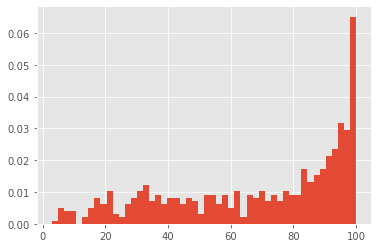

In [74]:
df.age.hist(bins=50,density=True);

Распределение логарифмов цен оказывается более похожим на нормальное.

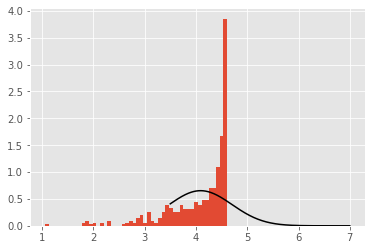

In [75]:
df.age.apply(np.log).hist(bins=50, density=True);

x = df.age.apply(np.log).values

xs = np.linspace(3.5, 7, 300)
ys = stats.norm(loc=np.mean(x), scale=np.std(x, ddof=1)).pdf(xs)
plt.plot(xs, ys, color="black");

Можно формально проверить гипотезу о том, имеет ли какая-то выборка нормальное распределение с помошью теста Колмогорова-Смирнова. О нём мы подробнее поговорим в будущем, а сейчас просто воспользуемся. 

In [76]:
stats.kstest(df.age, 'norm', args=(df.age.mean(), df.age.std(ddof=1)))

KstestResult(statistic=0.14809028064034857, pvalue=3.7664493497868145e-10)

In [77]:
stats.kstest(x, 'norm', args=(np.mean(x), np.std(x, ddof=1)))

KstestResult(statistic=0.19983721828448342, pvalue=3.463663746280753e-18)

В обоих ситуациях `pvalue` очень низкое, это говорит о том, что выборка не распределена нормально.

### Interval length
- The interval length (suppose we are using the general procedure) is:
$$L = 2 \times t_{\alpha / 2, \nu}  \sqrt{ \frac{s_A^2}{n} + \frac{s_B^2}{m}}$$

- Then the minimum number of samples  will be (supposing n = m)
$$n = m \geq \frac{4t_{\alpha / 2, \nu} (s^2_A + s^2_B)}{L_0^2}$$